In [2]:
import py3Dmol
import matplotlib.pyplot as plt

def plot_plddt_legend():
  thresh = ['plDDT:','Very low (<50)','Low (60)','OK (70)','Confident (80)','Very high (>90)']
  plt.figure(figsize=(1,0.1),dpi=100)
  ########################################
  for c in ["#FFFFFF","#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF"]:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False,
             loc='center', ncol=6,
             handletextpad=1,
             columnspacing=1,
             markerscale=0.5,)
  plt.axis(False)
  return plt

def plot_confidence(model_name='model_1_ptm', L=0):
  plt.figure(figsize=(10,3),dpi=100)
  """Plots the legend for plDDT."""
  #########################################
  plt.subplot(1,2,1); plt.title('Predicted lDDT')
  plt.plot(plddts[model_name])
  # for x in [L]:
  #   plt.plot([x,x],[0,100],color="black")

  plt.ylabel('plDDT')
  plt.xlabel('position')
  #########################################
  plt.subplot(1,2,2);plt.title('Predicted Aligned Error')
  plt.imshow(paes[model_name], cmap="bwr",vmin=0,vmax=30)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')
  #########################################
  return plt

def show_pdb(pdb_filename, target_filename='', model_name='AF2_model_1_ptm', show_sidechains=False, show_mainchains=False, color="lDDT"):
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_filename, 'r').read(),'pdb')
  if os.path.exists(target_filename):
      view.addModel(open(target_filename, 'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(2),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

In [10]:
# -----------------------------------------------------
# set config
# -----------------------------------------------------
import os

color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}


model_name = 'AF2_model_1_ptm'

protein_name = '7WNW_B'
target_filename = f'/Users/shuyu/Desktop/CASP_results/20220402/gt/{protein_name}/target.pdb'
fasta = f'/Users/shuyu/Desktop/CASP_results/20220402/gt/{protein_name}/target.fasta'
with open(fasta, 'r') as fh:
    target_name = fh.readlines()[0].strip()[1:]

pdb_path = '/Users/shuyu/Desktop/CASP_results/20220402/alphafold_model_1_ptm'
pdb_filename = os.path.join(pdb_path, 'unrelaxed', f'{target_name}_111.pdb')

out_filename = os.path.join(pdb_path, 'output', f'{target_name}_111.pkl')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

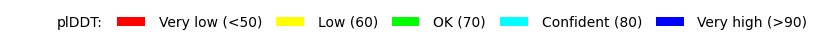

In [11]:
# -----------------------------------------------------
# 3D visualization
# -----------------------------------------------------

show_pdb(pdb_filename, target_filename, model_name, show_sidechains, show_mainchains, color).show()
if color == "lDDT": plot_plddt_legend().show()

model	plldt	pae_ab
AF2_model_1_ptm	71.67	15.01


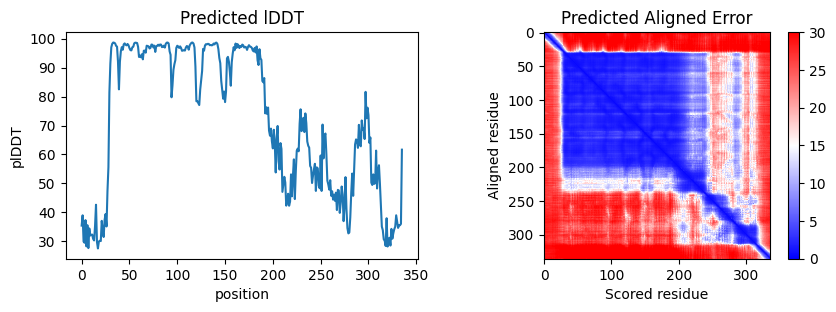

In [12]:
# -----------------------------------------------------
# plot plddt & pae
# -----------------------------------------------------

import numpy as np
import pickle as pkl

plddts_list = []
paes_list = []

out = pkl.load(open(out_filename, 'rb'))

plddts_list.append(out['plddt'])
paes_list.append(out['predicted_aligned_error'])


# rerank models based on predicted lddt
lddt_rank = np.mean(plddts_list, -1).argsort()[::-1]
plddts = {}
paes = {}
print("model\tplldt\tpae_ab")

L = out['msa'].shape[1]
for n,r in enumerate(lddt_rank):
    plddt = plddts_list[r].mean()
    pae_ab = paes_list[r].mean()
    print(f"{model_name}\t{plddt:.2f}\t{pae_ab:.2f}")

    plddts[model_name] = plddts_list[r]
    paes[model_name] = paes_list[r]

plot_confidence(model_name, L).show()